# Document Pipeline Visualization
Interactive visualization to compare layout detection and OCR results across all methods.

**Features:**
- Browse through filled documents with dropdown selector
- Side-by-side comparison of 3 layout detection methods
- View OCR results from all layout+OCR combinations
- Color-coded bounding boxes for each layout method

**Available Methods:**
- Layout: doclayout_yolo, doctr, surya
- OCR: easyocr, surya (tesseract requires binary install, paddleocr has Python 3.13 issues)

In [1]:
# Cell 1: Imports and Setup
import os
import json
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML, clear_output

# Try to import ipywidgets for interactive mode
try:
    import ipywidgets as widgets
    from ipywidgets import interact, Dropdown, Output, VBox, HBox, Label
    WIDGETS_AVAILABLE = True
    print("Interactive mode enabled (ipywidgets available)")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("Static mode (ipywidgets not available - install with: pip install ipywidgets)")

# Configuration
FILLED_DOCS_FOLDER = Path("filled_documents")
LAYOUT_RESULTS_FOLDER = Path("layout_results")
OCR_RESULTS_FOLDER = Path("ocr_results")

# Layout libraries and colors
LAYOUT_LIBRARIES = ["doclayout_yolo", "doctr", "surya"]
LAYOUT_COLORS = {
    "doclayout_yolo": "#FF6B6B",  # Red
    "doctr": "#4ECDC4",           # Teal
    "surya": "#45B7D1"            # Blue
}

# OCR libraries (currently working: easyocr, surya)
# tesseract requires binary install, paddleocr has Python 3.13 compatibility issues
OCR_LIBRARIES = ["easyocr", "surya"]

print("Setup complete!")
print(f"\nLayout methods: {', '.join(LAYOUT_LIBRARIES)}")
print(f"OCR methods: {', '.join(OCR_LIBRARIES)}")
print(f"Expected combinations per document: {len(LAYOUT_LIBRARIES)} × {len(OCR_LIBRARIES)} = {len(LAYOUT_LIBRARIES) * len(OCR_LIBRARIES)}")

Interactive mode enabled (ipywidgets available)
Setup complete!

Layout methods: doclayout_yolo, doctr, surya
OCR methods: easyocr, surya
Expected combinations per document: 3 × 2 = 6


In [2]:
# Cell 2: Data Discovery Functions

def get_filled_documents():
    """Get list of all filled document images."""
    docs = sorted([f.name for f in FILLED_DOCS_FOLDER.glob("*.png")])
    return docs

def get_layout_results(doc_name):
    """
    Find all layout JSON files for a given document.
    Returns dict: {library_name: json_data}
    """
    doc_stem = Path(doc_name).stem
    results = {}
    
    for lib in LAYOUT_LIBRARIES:
        json_path = LAYOUT_RESULTS_FOLDER / f"{doc_stem}_layout_{lib}.json"
        if json_path.exists():
            with open(json_path, 'r') as f:
                results[lib] = json.load(f)
    
    return results

def get_ocr_results(doc_name):
    """
    Find all OCR JSON files for a given document.
    Returns dict: {(layout_lib, ocr_lib): json_data}
    """
    doc_stem = Path(doc_name).stem
    results = {}
    
    for layout_lib in LAYOUT_LIBRARIES:
        for ocr_lib in OCR_LIBRARIES:
            json_path = OCR_RESULTS_FOLDER / f"{doc_stem}_ocr_{layout_lib}_{ocr_lib}.json"
            if json_path.exists():
                with open(json_path, 'r') as f:
                    results[(layout_lib, ocr_lib)] = json.load(f)
    
    return results

# Test data discovery
docs = get_filled_documents()
print(f"Found {len(docs)} filled documents:")
for i, d in enumerate(docs[:5]):
    print(f"  {i}: {d}")
if len(docs) > 5:
    print(f"  ... and {len(docs) - 5} more")

Found 24 filled documents:
  0: Demand Letter_batch_1.png
  1: Demand Letter_batch_1_1.png
  2: Demand Letter_batch_1_2.png
  3: Demand Letter_batch_1_3.png
  4: Demand Letter_batch_1_4.png
  ... and 19 more


In [3]:
# Cell 3: Visualization Functions

def draw_bboxes_on_image(image, regions, color, line_width=3):
    """
    Draw bounding boxes on an image.
    Returns a copy of the image with boxes drawn.
    """
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    
    for region in regions:
        bbox = region['bbox']
        x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
        
        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline=color, width=line_width)
        
        # Draw region type label
        label = f"{region['id']}: {region['type']}"
        draw.text((x1 + 2, y1 + 2), label, fill=color)
    
    return img_copy

def create_layout_comparison(doc_name, figsize=(18, 8)):
    """
    Create side-by-side layout comparison figure.
    """
    # Load original image
    img_path = FILLED_DOCS_FOLDER / doc_name
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return None
    
    original_img = Image.open(img_path).convert("RGB")
    
    # Get layout results
    layout_results = get_layout_results(doc_name)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f"Layout Detection Comparison: {doc_name}", fontsize=14, fontweight='bold')
    
    for idx, lib in enumerate(LAYOUT_LIBRARIES):
        ax = axes[idx]
        
        if lib in layout_results:
            data = layout_results[lib]
            img_with_boxes = draw_bboxes_on_image(
                original_img, 
                data['regions'], 
                LAYOUT_COLORS[lib]
            )
            ax.imshow(img_with_boxes)
            ax.set_title(f"{lib}\n({len(data['regions'])} regions)", 
                        color=LAYOUT_COLORS[lib], fontweight='bold')
        else:
            ax.imshow(original_img)
            ax.set_title(f"{lib}\n(No results)", color='gray')
        
        ax.axis('off')
    
    plt.tight_layout()
    return fig

def create_ocr_summary(doc_name):
    """
    Create text summary of OCR results.
    """
    ocr_results = get_ocr_results(doc_name)
    
    if not ocr_results:
        return "No OCR results available for this document."
    
    output_lines = []
    output_lines.append(f"\n{'='*70}")
    output_lines.append(f"OCR RESULTS SUMMARY: {doc_name}")
    output_lines.append(f"{'='*70}")
    
    for layout_lib in LAYOUT_LIBRARIES:
        output_lines.append(f"\n▶ Layout: {layout_lib}")
        output_lines.append("-" * 50)
        
        has_results = False
        for ocr_lib in OCR_LIBRARIES:
            key = (layout_lib, ocr_lib)
            if key in ocr_results:
                has_results = True
                data = ocr_results[key]
                output_lines.append(f"  ├─ {ocr_lib.upper()}:")
                
                # Show first few regions
                for region in data['regions'][:3]:
                    text = region['ocr']['full_text'][:60]
                    if len(region['ocr']['full_text']) > 60:
                        text += "..."
                    output_lines.append(f"     [{region['type']}] {text}")
                
                if len(data['regions']) > 3:
                    output_lines.append(f"     ... and {len(data['regions']) - 3} more regions")
        
        if not has_results:
            output_lines.append("  └─ No OCR results available")
    
    return "\n".join(output_lines)

def display_full_ocr_text(doc_name, layout_lib, ocr_lib):
    """
    Display full OCR text for a specific layout+OCR combination.
    """
    ocr_results = get_ocr_results(doc_name)
    key = (layout_lib, ocr_lib)
    
    if key not in ocr_results:
        return f"No results for {layout_lib} + {ocr_lib}"
    
    data = ocr_results[key]
    output_lines = []
    output_lines.append(f"\nFull OCR Text ({layout_lib} + {ocr_lib})")
    output_lines.append("=" * 50)
    
    for region in data['regions']:
        output_lines.append(f"\n[{region['type']}] (conf: {region['layout_confidence']:.2f})")
        output_lines.append(region['ocr']['full_text'])
    
    return "\n".join(output_lines)

print("Visualization functions loaded!")

Visualization functions loaded!


In [4]:
# Cell 4: Interactive Document Browser (if ipywidgets available)

if WIDGETS_AVAILABLE:
    docs = get_filled_documents()
    
    # Create widgets
    doc_dropdown = Dropdown(
        options=docs,
        value=docs[0] if docs else None,
        description='Document:',
        style={'description_width': '80px'},
        layout={'width': '400px'}
    )
    
    output_area = Output()
    
    def on_document_change(change):
        """Handle document selection change."""
        with output_area:
            clear_output(wait=True)
            doc_name = change['new']
            
            print(f"\n📄 Selected: {doc_name}")
            print("=" * 70)
            
            # Show layout comparison
            print("\n🔍 Layout Detection Comparison:")
            fig = create_layout_comparison(doc_name)
            if fig:
                plt.show()
            
            # Show OCR summary
            print(create_ocr_summary(doc_name))
    
    # Connect callback
    doc_dropdown.observe(on_document_change, names='value')
    
    # Display UI
    display(HTML("<h2>📊 Document Pipeline Visualization</h2>"))
    display(HTML("<p>Select a document to view layout detection and OCR results:</p>"))
    display(doc_dropdown)
    display(output_area)
    
    # Trigger initial display
    on_document_change({'new': doc_dropdown.value})
else:
    print("Interactive widgets not available. Use the static view in the next cell.")

Dropdown(description='Document:', layout=Layout(width='400px'), options=('Demand Letter_batch_1.png', 'Demand …

Output()

Total documents: 24

Document list:
  → [0] Demand Letter_batch_1.png
    [1] Demand Letter_batch_1_1.png
    [2] Demand Letter_batch_1_2.png
    [3] Demand Letter_batch_1_3.png
    [4] Demand Letter_batch_1_4.png
    [5] Demand Letter_batch_1_5.png
    [6] Demand Letter_batch_2.png
    [7] Demand Letter_batch_2_1.png
    [8] Demand Letter_batch_2_2.png
    [9] Demand Letter_batch_2_3.png
    [10] Demand Letter_batch_2_4.png
    [11] Demand Letter_batch_2_5.png
    [12] Demand Letter_filled_computer.png
    [13] Demand Letter_filled_computer_1.png
    [14] Demand Letter_filled_computer_2.png
    [15] Demand Letter_filled_computer_3.png
    [16] Demand Letter_filled_computer_4.png
    [17] Demand Letter_filled_computer_5.png
    [18] Demand Letter_filled_handwriting.png
    [19] Demand Letter_filled_handwriting_1.png
    [20] Demand Letter_filled_handwriting_2.png
    [21] Demand Letter_filled_handwriting_3.png
    [22] Demand Letter_filled_handwriting_4.png
    [23] Demand Letter_fille

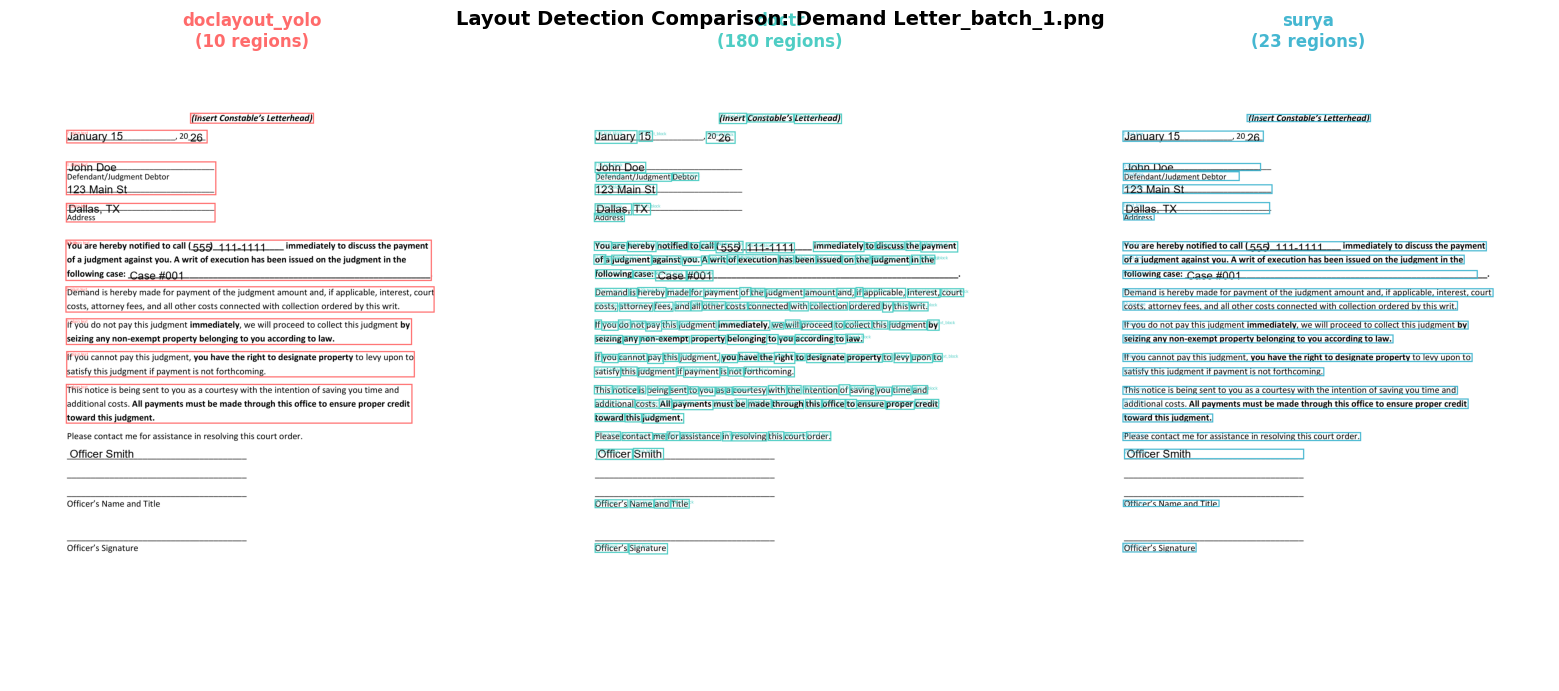


OCR RESULTS SUMMARY: Demand Letter_batch_1.png

▶ Layout: doclayout_yolo
--------------------------------------------------
  ├─ EASYOCR:
     [plain text] If you do not pay this judgment immediately, we will proceed...
     [plain text] Demand is hereby made for payment of the judgment amount and...
     [plain text] If you cannot pay this judgment; you have the right to desig...
     ... and 7 more regions
  ├─ SURYA:
     [plain text] If you do not pay this judgment <b>immediately</b>, we will ...
     [plain text] Demand is hereby made for payment of the judgment amount and...
     [plain text] If you cannot pay this judgment, <b>you have the right to de...
     ... and 7 more regions

▶ Layout: doctr
--------------------------------------------------
  ├─ EASYOCR:
     [text_block] Signature
     [text_block] Officer' s
     [text_block] Name
     ... and 177 more regions
  ├─ SURYA:
     [text_block] Signature
     [text_block] Officer's
     [text_block] Name
     ... and 177 m

In [5]:
# Cell 5: Static Single Document View (fallback or manual selection)

# ============================================================
# CONFIGURATION: Change this index to view different documents
# ============================================================
DOCUMENT_INDEX = 0  # Change this to view different documents (0 to n-1)

docs = get_filled_documents()
print(f"Total documents: {len(docs)}")
print(f"\nDocument list:")
for i, d in enumerate(docs):
    marker = "→" if i == DOCUMENT_INDEX else " "
    print(f"  {marker} [{i}] {d}")

if docs:
    selected_doc = docs[DOCUMENT_INDEX]
    print(f"\n{'='*70}")
    print(f"VIEWING: {selected_doc}")
    print(f"{'='*70}")
    
    # Show layout comparison
    print("\n🔍 Layout Detection Comparison:")
    fig = create_layout_comparison(selected_doc, figsize=(16, 7))
    if fig:
        plt.show()
    
    # Show OCR summary
    print(create_ocr_summary(selected_doc))
else:
    print("No documents found in filled_documents/ folder.")

In [6]:
# Cell 6: Detailed OCR Comparison (Optional)
# View full OCR text for a specific layout+OCR combination

# ============================================================
# CONFIGURATION: Select document, layout, and OCR library
# ============================================================
DOCUMENT_INDEX = 0
LAYOUT_LIB = "doclayout_yolo"  # Options: "doclayout_yolo", "doctr", "surya"
OCR_LIB = "easyocr"            # Options: "easyocr", "surya"

docs = get_filled_documents()
if docs:
    selected_doc = docs[DOCUMENT_INDEX]
    print(display_full_ocr_text(selected_doc, LAYOUT_LIB, OCR_LIB))
else:
    print("No documents available.")


Full OCR Text (doclayout_yolo + easyocr)

[plain text] (conf: 0.94)
If you do not pay this judgment immediately, we will proceed to collect this judgment by seizing any non-exempt property belonging to you according to law:

[plain text] (conf: 0.93)
Demand is hereby made for payment of the judgment amount and, if applicable, interest, cour costs, attorney fees, and all other costs connected with collection ordered by this writ_

[plain text] (conf: 0.92)
If you cannot pay this judgment; you have the right to designate property to levy upon to satisfy this judgment if payment is not forthcoming

[plain text] (conf: 0.92)
This notice is being sent to you as a courtesy with the intention of saving you time and additional costs. All payments must be made through this office to ensure proper credit toward this judgment

[title] (conf: 0.86)
(Insert Constable'$ Letterhead)

[plain text] (conf: 0.79)
John Doe Defendant/Judgment Debtor 123 Main St

[plain text] (conf: 0.64)
January 15 2026



In [7]:
# Cell 7: Results Availability Matrix
# Shows which layout+OCR combinations have results for each document

docs = get_filled_documents()

print("Results Availability Matrix")
print("=" * 80)
print(f"\n{'Document':<45} | Layout Results | OCR Results")
print("-" * 80)

for doc in docs:
    layout_results = get_layout_results(doc)
    ocr_results = get_ocr_results(doc)
    
    layout_libs = ", ".join(layout_results.keys()) if layout_results else "None"
    
    ocr_combos = []
    for key in ocr_results.keys():
        ocr_combos.append(f"{key[0][:3]}+{key[1][:3]}")
    ocr_str = ", ".join(ocr_combos) if ocr_combos else "None"
    
    doc_short = doc[:43] + ".." if len(doc) > 45 else doc
    print(f"{doc_short:<45} | {len(layout_results):^14} | {len(ocr_results):^11}")

print("-" * 80)
print(f"\nTotal documents: {len(docs)}")
print(f"Layout libraries: {', '.join(LAYOUT_LIBRARIES)}")
print(f"OCR libraries: {', '.join(OCR_LIBRARIES)}")

Results Availability Matrix

Document                                      | Layout Results | OCR Results
--------------------------------------------------------------------------------
Demand Letter_batch_1.png                     |       3        |      6     
Demand Letter_batch_1_1.png                   |       0        |      0     
Demand Letter_batch_1_2.png                   |       0        |      0     
Demand Letter_batch_1_3.png                   |       0        |      0     
Demand Letter_batch_1_4.png                   |       0        |      0     
Demand Letter_batch_1_5.png                   |       0        |      0     
Demand Letter_batch_2.png                     |       0        |      0     
Demand Letter_batch_2_1.png                   |       0        |      0     
Demand Letter_batch_2_2.png                   |       0        |      0     
Demand Letter_batch_2_3.png                   |       0        |      0     
Demand Letter_batch_2_4.png                